In [1]:
import numpy as np
import pandas as pd
import xgboost as xb
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
data = load_boston()
X = data.data
y = data.target
cols = data.feature_names

In [3]:
trainX, testX, trainY, testY = train_test_split(X,y)

In [4]:
dTrainMatrix = xb.DMatrix(trainX, trainX)
dTestMatrix = xb.DMatrix(testX, testY)

In [5]:
untuned_params = {"objective":"reg:linear"}
cv_results = xb.cv(params=untuned_params, dtrain=dTrainMatrix, metrics="rmse", num_boost_round=5, nfold=3, as_pandas=True)
print (cv_results['test-rmse-std'][4])

10.820280981809328


# Try Basic Model Tuning

    - In this approach we simply create a for loop and for different values of boosting_rounds we find the RMSE.
    - Depending on which value of boosting round gives us the best RMSE we can choose that as final parameter
    - We can also think of multiple for loops (a for loop within a for loop) to test combination of parameters

In [6]:
boosting_rounds = [3,5,11,15,20,30,50]
untuned_params = {"objective":"reg:linear"}

metrics_vals = []
for b_round in boosting_rounds:
    cv_results = xb.cv(params=untuned_params, early_stopping_rounds=10, dtrain=dTrainMatrix, metrics="rmse",num_boost_round=b_round, nfold=3, as_pandas=True)
    metrics_vals.append(cv_results['test-rmse-std'].tail().values[-1])

df = pd.DataFrame(list(zip(boosting_rounds, metrics_vals)), columns=['Boosting Rounds','RMSE'])
df

,Boosting Rounds,RMSE
0,3,9.631885
1,5,10.820281
2,11,10.409649
3,15,8.893266
4,20,8.893266
5,30,8.893266
6,50,8.893266


# Hyper parameter tuning using GridSearchCV

    - GridSearchCV is like a brute force attack where all possible combinations of hyper parameters are evaluated. For e.g.
    if there are 2 hp and each hp has 3 values and we have 4 folds (cross validation datasets) then GridSearchCV will try (2*3=6 models), 4 times
    
    - Code wise this works as follows:
        - Create a dictionary of fixed_params ; those params which we are keeping as same
        - Create a dictionary of variable_params
        - Create GridSearchCV() object passing in the following:
            - XGBClassifier or XGBRegressor; in this we pass the fixed params
            - variable_params
            - cv = 2/3/4/5/6 (Number of Folds or datasets)
            - scoring = '' (scoring approach depending on Regression or Classification)

In [7]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold

In [8]:
data = load_boston()
X = data.data
y = data.target
cols = data.feature_names

In [48]:
fixed_params = {"objective":"reg:linear"}

variable_params = {"max_depth":np.arange(1,20,5),
                  "learning_rate":np.arange(0.1,0.3,0.1),
                  "subsamples":np.arange(0.1,0.8,0.2),
                  "alpha":np.arange(0.1,0.8,0.2),
                  "num_boost_round":np.arange(5,20,5)}
gs_cv = GridSearchCV(XGBRegressor(**fixed_params),variable_params,cv=3, n_jobs=4, scoring='neg_mean_squared_error')
gs_cv.fit(X,y)

C:\Users\rahuljain08\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': array([ 1,  6, 11, 16]), 'learning_rate': array([0.1, 0.2]), 'subsamples': array([0.1, 0.3, 0.5, 0.7]), 'alpha': array([0.1, 0.3, 0.5, 0.7]), 'num_boost_round': array([ 5, 10, 15])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [49]:
print ('Best parameters found are:',gs_cv.best_params_)

Best parameters found are: {'alpha': 0.1, 'learning_rate': 0.1, 'max_depth': 11, 'num_boost_round': 5, 'subsamples': 0.1}


In [50]:
print ('Best score found is:', np.sqrt(np.abs(gs_cv.best_score_)))

Best score found is: 5.1046060530540585


In [51]:
pred_Y = gs_cv.predict(X)

# Hyper parameter tuning using RandomSearchCV

    - RandomSearchCV extends the functionality from GridSearchCV
    - Just like in GridSearchCV we define the hyper-parameters we want to find, however unlike GridSearchCV, in RandomSearchCV we specify the number of iterations (or models) we want to evaluate. These models are then drawn from the combinations of different hyper-parameter values.
    - To test the impact of number of threads (jobs) being used for cross validation we would iterate through an array with various values of n_jobs and record the time it takes to do CV. We then plot a graph for n_jobs and time_taken to see the visuals

In [13]:
from sklearn.model_selection import RandomizedSearchCV

In [40]:
fixed_params = { "objective":"reg:linear",
                 "scoring":"neg_mean_squared_error"}
variable_params = {"max_depth":np.arange(1,20,3),
                  "learning_rate":np.arange(0.1,0.3,0.05),
                  "subsamples":np.arange(0.1,0.9,0.1),
                  "alpha":np.arange(0.1,0.9,0.1),
                  "n_iter":[10,20,30,40,50],
                  "num_boost_round":np.arange(5,25,5)}

C:\Users\rahuljain08\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\rahuljain08\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\rahuljain08\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Text(0, 0.5, 'Time taken for CV(seconds)')

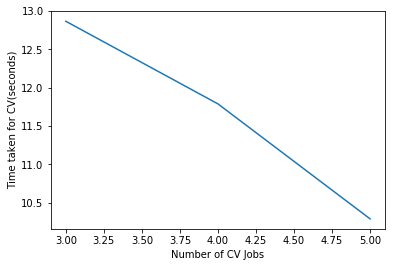

In [53]:
from time import time

jobs = [3,4,5]
time_taken = []

# To test the impact of number of threads (jobs) being used for cross validation we would iterate through an array with various
# values of n_jobs and record the time it takes to do CV. We then plot a graph for n_jobs and time_taken to see the visuals.
for job in jobs:
    start = time()
    rs_cv = RandomizedSearchCV(XGBRegressor(**fixed_params), variable_params, n_jobs=job, n_iter=70, cv=4, )
    rs_cv.fit(X,y)
    end = time()
    time_taken.append(end-start)
    
plt.plot(jobs, time_taken)
plt.xlabel('Number of CV Jobs')
plt.ylabel('Time taken for CV(seconds)')

In [54]:
print ('Best parameters are:', rs_cv.best_params_)
print ('Best score is:', np.sqrt(np.abs(rs_cv.best_score_)))

Best parameters are: {'subsamples': 0.5000000000000001, 'num_boost_round': 10, 'max_depth': 11, 'learning_rate': 0.2, 'alpha': 0.7000000000000001}
Best score is: 0.7761735980232913


# Number of Threads & Model Training Time Graph

    - Here we try to find relationship b/w the time it takes to train the model as the number of threads for tree creation increase.
    - We would use the hyper parameters which were identified in the sections above

Text(0, 0.5, 'Time Taken')

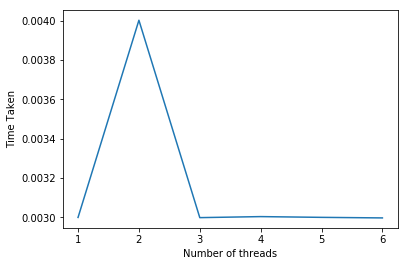

In [55]:
from time import time

num_threads = [1,2,3,4,5,6]

time_taken  = []
for thread in num_threads:
    start = time()
    xgb_reg = xb.XGBRegressor(max_depth=4, learning_rate=0.2, subsample=0.1, objective="reg:linear", n_estimators=5, reg_alpha=0.7, nthread=thread)
    model = xgb_reg.fit(X,y)
    end = time()
    time_taken.append(end-start)
    
plt.plot(num_threads, time_taken)
plt.xlabel('Number of threads')
plt.ylabel('Time Taken')